# Building the Digraph
By parsing csv files, we create the directed graph representing who follows who in the NBA. A directed edge goes **from A to B, if A follows B**.


In [1]:
# dependencies and constants
import os, csv, operator
import numpy as np
from sklearn.preprocessing import normalize
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline
FILE_EXT_NUM = -14
FILE_EXT     = "_processed.csv"
DIR          = "../processed"

In [2]:
# create digraph
G = nx.DiGraph()

In [3]:
# add a node for each player
os.chdir(DIR)
for file in os.listdir():
    if file[-14:] == FILE_EXT: # ignore hidden files
        G.add_node(file[:FILE_EXT_NUM])

In [4]:
# add directed edges between players
for node in G.adj:
    with open(str(node + FILE_EXT), 'r') as file:
        for line in file.readlines():
            line = line.strip()
            for player in G.adj:
                if player == line and player != node:
                    G.add_edge(node, line)

In [23]:
# save graph to json file
# json = nx.node_link_data(G)
# with open("../../graph/graph.json", "w") as f:
#     f.write(str(json))

# save graph as .graphml file
nx.write_graphml(G, "../../graph/graph.graphml")

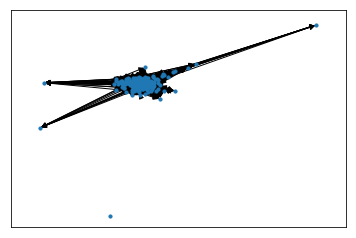

In [6]:
# print graph
nx.draw_networkx(G, with_labels=False, node_size=10)
plt.draw()
plt.show()

In [5]:
# Find players who don't follow any other players
for player in G.nodes:
    others = 0
    for neighbor in G.neighbors(player):
        others += 1
    if (others == 0):
        print(player)

markellefultz
supermariohezonja
abrooksart
eneskanter11


# Computing Importance with PageRank
In this section, we compute the importance score of each player in the network. We do this through two methods: first, a manual computation using the ```numpy``` library; then, a one-line computation with ```networkx``` built-in methods as a correctness check. We also compute importance with a variety of other metrics, including eigenvector centrality. 

In [5]:
# compute H matrix (normalized with no all-zero rows)
A = nx.adjacency_matrix(G).todense()
dim = A.shape[0]
row_sums = A.sum(axis=1)
H = normalize(A, axis=1, norm='l1')
for i in range(0, dim):
    if int(row_sums[i]) is 0:
        for j in range(len(H[i])):
            H[i, j] = 1.0/dim

# Ensure there are no zero rows
# row_sums_2 = H.sum(axis=1)
# for row_sum in row_sums_2:
#     if row_sum == 0:
#         print("zero row sum")

# perform iterations to get the importance vector
theta = 0.85

# Compute Google Matrix
G_matrix = theta * H + (1 - theta) * (1.0 / dim) * np.ones((dim, dim))

# Set an initial pi vector (normalized)
pi = np.ones(dim)
for i in range(0, dim):
    if i is not 0:
        pi[i] = 0

# Perform 1000 iterations of PageRank
for i in range(0, 1000):
    pi = pi.dot(G_matrix)
# print(np.sort(pi))

In [6]:
# Add follower count to an associative array
os.chdir("../scripts/count")
counts = {}
with open("counts.csv", "r") as f:
    reader = csv.reader(f)
    for line in reader:
        counts[line[0]] = line[1]
#         print(line[0] + "," + line[1])

os.chdir("../../processed")

#### Compute Eigenvector, Betweenness, Load Centrality, and PageRank Importance

In [27]:
# Do PageRank with networkx built in method. Ensure output 
# identical to the above results. 
pr = nx.pagerank(G, alpha = 0.85)
pagerank = sorted(pr.items(), key=operator.itemgetter(0))
eigen    = sorted(nx.eigenvector_centrality(G).items(), key=operator.itemgetter(0))
load     = sorted(nx.load_centrality(G).items(), key=operator.itemgetter(0))
betw     = sorted(nx.betweenness_centrality(G).items(), key=operator.itemgetter(0))

with open("metrics.csv", "w") as f:
    f.write("username,pagerank,eigen,load,betw,followers\n")
    
with open("metrics.csv", "a") as f:
    for i in range(len(pagerank)):
        foundFollowers = False
        f.write(pagerank[i][0] + "," + str(pagerank[i][1]) + "," + str(eigen[i][1]) + "," 
                  + str(load[i][1]) + "," + str(betw[i][1]) + ",")
        for key, value in counts.items():
            if str(pagerank[i][0]) == str(key):
                f.write(str(value) + "\n")
                foundFollowers = True
        if not foundFollowers:
            f.write("\n")
        

os.rename("./metrics.csv", "../scripts/metrics.csv")

# Print importance scores in order of most to least important
pr_sorted = sorted(pr.items(), key=operator.itemgetter(1), reverse=True)
eigen_sorted = sorted(nx.eigenvector_centrality(G).items(), key=operator.itemgetter(1), reverse=True)
load_sorted = sorted(nx.load_centrality(G).items(), key=operator.itemgetter(1), reverse=True)
betw_sorted = sorted(nx.betweenness_centrality(G).items(), key=operator.itemgetter(1), reverse=True)
# for item in METRIC_sorted:
#     print(item)

# Plotting All-Star votes against Importance
Here, for a small subset of players we plot their All-Star votes against their importance score to discern some sort of relationship. 

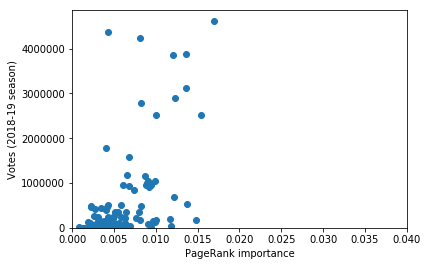

mean importance: 0.005329324920630084


In [9]:
# Change working directory
if os.getcwd()[-13:] != "allstar-votes":
    os.chdir("../../allstar-votes")

# Get the importance of a given player
def get_imp(username):
    for player in pr_sorted:
        if player[0] == username:
            return player[1]
    return -1 # if importance not found

# Get the votes for a given player, in 2018-19 season
def get_votes_19(name):
    os.chdir("./votes")
    with open("votes19.csv", "r") as f:
        reader = csv.reader(f)
        for line in reader:
            if line[0] == name:
                os.chdir("..")
                return line[1]
    os.chdir("..")
    return -1 # if votes not found
    
# Store players, their votes, and their importance
stats = {}
with open("names-and-handles.csv", "r") as f:
    reader = csv.reader(f)
    for line in reader:
        if line[1] and line[1] != "null": # if there is a username
            stats[line[0]] = {
                'username': line[1],
                'imp': get_imp(line[1]),
                'votes': get_votes_19(line[0]),
            }

# Plot votes against importance (importance: X-axis, votes: Y-axis)
imp   = []
votes = []
for player, stat in stats.items():
    if stat['imp'] != -1 and stat['votes'] != -1:
        imp.append(float(stat['imp']))
        votes.append(float(stat['votes']))
plt.scatter(imp, votes)
plt.xticks([0, 0.005, 0.01, 0.015, 0.02, 0.025, 0.03, 0.035, 0.04])
plt.xlim(left=0)
plt.ylim(bottom=0)
plt.xlabel('PageRank importance')
plt.ylabel('Votes (2018-19 season)')
plt.show()

# Print mean
print('mean importance: ', end='')
print(np.mean(imp))